In [1]:
import numpy as np
import sep
import astropy

In [2]:
# additional setup for reading the test image and displaying plots
import astropy
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

image_file = get_pkg_data_filename('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')

In [4]:
fits.info(image_file)

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     358   (3600, 3600)   float32   


In [5]:
#read the image data from this first extension using the keyword argument ext=0
image_data = fits.getdata(image_file, ext=0)

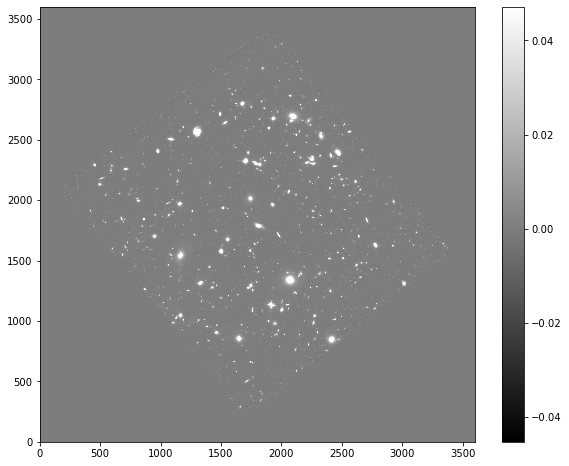

In [6]:
#show the image
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("f160w.png")

In [7]:
# measure a spatially varying background on the image
image_data = image_data.byteswap().newbyteorder()
bkg = sep.Background(image_data)

In [8]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0004939954960718751


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
#bkg_image = np.array(bkg) # equivalent to above

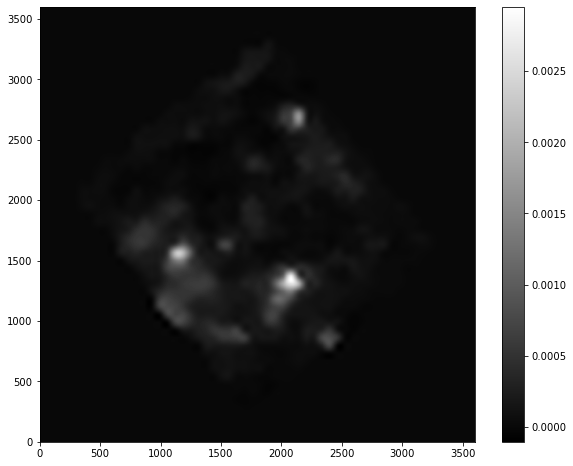

In [10]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("f160w_background.png")

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

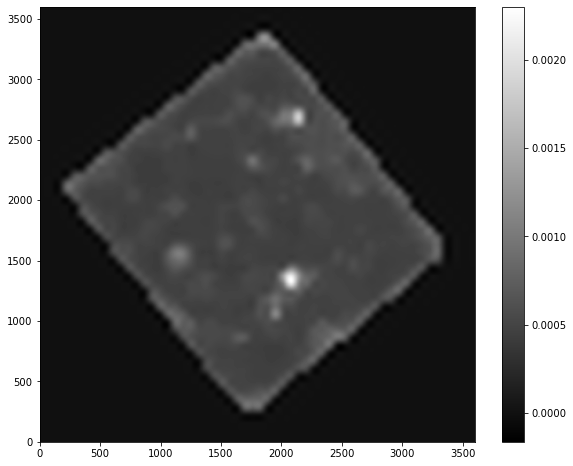

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("f160w_background_noise.png")

In [13]:
# subtract the background
data_sub = image_data - bkg

In [14]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [15]:
# how many objects were detected
len(objects)

7643

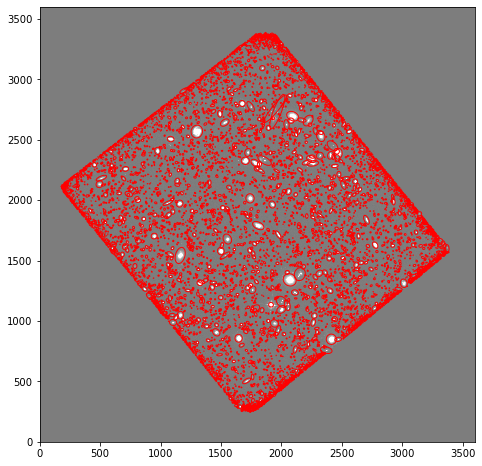

In [16]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("f160w_background-subtracted.png")

In [17]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [18]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.016474 +/- 0.128376
object 1: flux = 0.018756 +/- 0.136979
object 2: flux = -0.002026 +/- 0.002623
object 3: flux = 0.021292 +/- 0.145940
object 4: flux = 0.018956 +/- 0.137706
object 5: flux = 0.008721 +/- 0.093422
object 6: flux = 0.014634 +/- 0.121000
object 7: flux = 0.046033 +/- 0.214570
object 8: flux = 0.015850 +/- 0.125923
object 9: flux = -0.019229 +/- 0.002623


(array([7.636e+03, 5.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.92287356e-02,  6.53465483e+01,  1.30712325e+02,  1.96078102e+02,
         2.61443880e+02,  3.26809657e+02,  3.92175434e+02,  4.57541211e+02,
         5.22906988e+02,  5.88272765e+02,  6.53638542e+02]),
 <BarContainer object of 10 artists>)

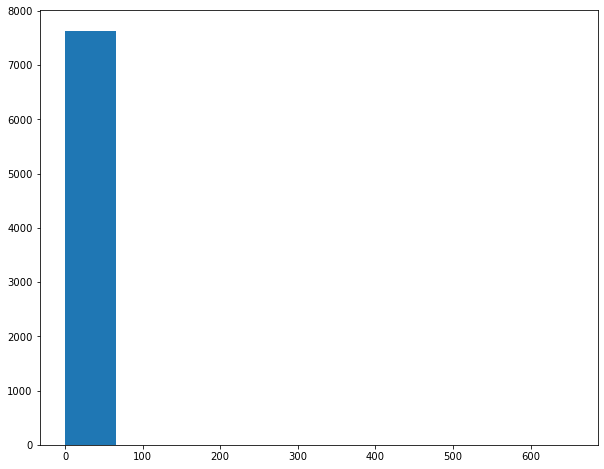

In [19]:
plt.hist(flux)